
_Written by Célia Desgrange, 2022-12-13. 
_Revised by Célia:_

In [1]:
import glob
import numpy as np
import time, os

#from astropy.convolution import (convolve_fft, convolve, Gaussian2DKernel)

#import vip_hci as vip
#from astropy.io import fits
#import cv2 

from import_functions_generic import * 
from import_functions_plotting import * 
#from image_manipulation import * 

In [2]:
plt.style.use('classic')  
mpl.rc('image', cmap='viridis')#, origin='lower')
#mpl.rc('text', usetex=True)
#mpl.rc(mathtext.fontset = 'stix')


rcParams.update({'font.size': 14,  'axes.labelsize' : 14, 'legend.fontsize' : 12,
"font.family": "serif", 'text.usetex' : True, "font.serif": [], "font.sans-serif": [],
'legend.handlelength': 1.5, 'legend.borderaxespad' : 0.8, 'legend.columnspacing' : 1, 'legend.handletextpad' : 0.5})

rcParams['mathtext.fontset'] = 'stix'

In [3]:
L = time.localtime()
date = "{}-{}-{}".format(L[0],L[1],L[2],L[3],L[4],L[5])

saving_dir = 'figs/fig_v{}/'.format(date)
os.makedirs(saving_dir,exist_ok=True)

# I. Load an observation

In [5]:
# Initialize the path to the wished data 
# -> supposed to be changed accordingly to the data/computer used
infolder = '/Users/desgranc/Documents/work/projects/HD120326/data/'
folder_prereduced = 'prereduced/convert/'
folder_reduced = 'reduced/'
dF       = pd.read_csv(infolder + 'list_obs.txt',sep='\t')
dF

,target,epoch,instrument,polar,filter,quality,"seeing ("")",tau0 (ms),delta pa (deg),PI,DIT (s),Nb frames,Total exposure (min)
0,HD_120326,2016-04-05,IRDIS,no,H23,good,1.1,3.5,37,Bonnefoy & Ménard,32.0,128.0,68.0
1,HD_120326,2016-06-03,IRDIS,no,H23,good,0.71,3.1,22,Hinkley & Matthews,32.0,80.0,43.0
2,HD_120326,2016-06-13,IRDIS,no,J23,to check,to check,to check,NaN,GTO,NaN,NaN,NaN
3,HD_120326,2018-06-01,IRDIS,yes,BB_H,very good,0.45,4.2,Boccaletti,NaN,NaN,NaN,NaN
4,HD_120326,2019-06-26,IRDIS,no,BB_H,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
5,HD_120326,2019-07-09,IRDIS,no,BB_H,very good,0.54,3.1,58,Bonnefoy & Ménard,32.0,224.0,119.0
6,HD_120326,2016-04-05,IFS,no,YJ,good,1.1,3.5,37,Bonnefoy & Ménard,64.0,64.0,68.0
7,HD_120326,2016-06-03,IFS,no,YJ,good,0.71,3.1,22,Hinkley & Matthews,64.0,40.0,43.0
8,HD_120326,2019-06-26,IFS,no,YJ,very bad,1.84,2.4,36,Bonnefoy & Ménard,NaN,NaN,NaN
9,HD_120326,2019-07-09,IFS,no,YJ,very good,0.54,3.1,58,Bonnefoy & Ménard,64.0,112.0,119.0


In [6]:
idx, idx_pcs, before_or_after,sorting = 9, 10, 'before','sorting' #'softsorting'
epoch = str(dF['epoch'].iloc[idx])
filt =  str(dF['filter'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'PCA_Celia/fits/SCIENCE/'

path_im_reduced = infolder + folder_reduced + algo + '*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[1])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/*2019-07-09*before*sorting_cube_im_pca.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_J_20-38_both_channels_combine_before_Nonesorting_cube_im_pca.fits
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_Y_2-17_both_channels_combine_before_Nonesorting_cube_im_pca.fits


# General parameters

In [32]:
# Image - observation
pixel_scale=0.01225 # pixel scale in arcsec/px 
#pixel_scale=0.00746
platescale = pixel_scale*1e3
scalebar_pix, scalebar_leg = 1000, '1"'
nx = 624 # number of pixels of your image in X
ny = 624 # number of pixels of your image in Y

# Save file .fits
writeto = False # save .fits file

# Figure
add_colorbar=0
figsize_rectange, figsize_square  = (4,3), (3,3)
figsize = np.where(add_colorbar, figsize_rectange, figsize_square)
left, right = 0.01, float(np.where(add_colorbar, 0.78, 0.99))
top, bottom = float(np.where(add_colorbar, 0.95, 0.99)), float(np.where(add_colorbar, 0.05, 0.01))
im_crop = 250
save_png = 0    # save .png file
cbar_xdeb = 0.83
scalebar_pix, scalebar_leg = 100, '0.1"'

text_xfrac, text_yfrac = 0.03, 0.84
filt='H'

## PCA

### IRDIS

In [127]:
#IRDIS 
idx, idx_pcs, before_or_after,sorting = 5, 9, 'after', 'sorting'
epoch = str(dF['epoch'].iloc[idx])
filt =  str(dF['filter'].iloc[idx])
if filt == 'BB_H': filt = 'H'
if filt == 'H23': filt = 'H23'
    
print('Load the epoch: {}'.format(epoch))
algo = 'PCA'
algo_folder = algo + '_Celia/fits/zold/SCIENCE/'
path_im_reduced = infolder + folder_reduced + algo_folder + '*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/zold/SCIENCE/*2019-07-09*after*sorting_cube_im_pca.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/zold/SCIENCE/2019-07-09_IRDIS_BB_H_both_channels_combine_after_softsorting_cube_im_pca.fits


##### Without color bar

Size of the image = 624 and crop PCA = 250 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_contrast_pca_2019-07-09_H_10ncomp_vmax1


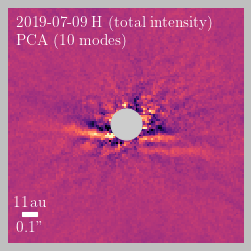

In [156]:
add_colorbar = 0
figsize_cbar = (4,3)
clab = r'contrast'

namesave = 'im_contrast_pca_{}_{}_{}ncomp_vmax1'.format(epoch,filt,idx_pcs+1)
im = np.copy(im_reduced)
im_crop_PCA = 244+6
im_crop = im_crop_PCA

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = '$S/N$'
if epoch == '2019-07-09': vminmax = 1.2e-7
elif epoch == '2016-06-03': vminmax = 1.6e-7
elif epoch == '2016-04-05': vminmax = 1.6e-7
    
vmin, vmax = -vminmax,vminmax
text = '{} {} (total intensity) \n{} ({} modes)'.format(epoch, filt, algo, idx_pcs+1)
#text = '{} {} (total intensity)\n{}'.format(epoch, filt.replace('BB_',''), algo)


fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_edges_nb=11,
         cbar_xdeb=0.81, cbar_ydeb=0.05, cbar_xwidth=0.04, cbar_ywidth=0.9,
         add_text=1, text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=0.99, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)

# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)

    
print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

##### With color bar

Size of the image = 624 and crop PCA = 250 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-9-12/im_contrast_pca_2019-07-09_H_10ncomp_cbar_vmax1


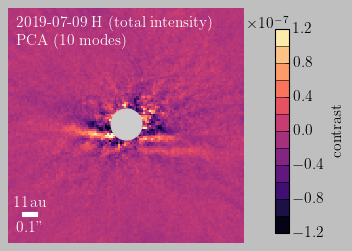

In [155]:
add_colorbar = 1
figsize_cbar = (4.3,3)
clab = r'contrast'

namesave = 'im_contrast_pca_{}_{}_{}ncomp_cbar_vmax1'.format(epoch,filt,idx_pcs+1)
im = np.copy(im_reduced)
im_crop_PCA = 244+6
im_crop = im_crop_PCA

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 'i.e. size of the image shown =',  len(im)-2*im_crop)

vmin, vmax = -vminmax, vminmax
text = '{} {} (total intensity) \n{} ({} modes)'.format(epoch, filt, algo, idx_pcs+1)
#text = '{} {} (total intensity)\n{}'.format(epoch, filt.replace('BB_',''), algo)


fig, ax = plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_arcsec=scalebar_pix, scalebar_leg=scalebar_leg, 
         scalebar_label_top=0, scalebar_sep=scalebar_sep, scalebar_pad=scalebar_pad,
         platescale=platescale, figsize=figsize_cbar,
         add_colorbar=add_colorbar, clab=clab, cbar_edges_nb=13,
         cbar_xdeb=0.79, cbar_ydeb=0.05, cbar_xwidth=0.04, cbar_ywidth=0.85,
         add_text=1, text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac, color_text='white',
         right=0.7, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave,
        give_fig_ax=False, return_fig_ax=True, do_tight_layout=0)
 
# Add scale bar au
ax.text(text_xfrac*0.8,0.155, scalebar_au, color='white', transform=ax.transAxes)

# Add IWA
h, w = n_final, n_final
r_IWA = 100
IWA_color = [0.8,0.8,0.8]
circle = Circle((h/2,w/2),r_IWA/platescale,ec=IWA_color,fc=IWA_color,ls='-',lw=1)
ax.add_patch(circle)

    
print('The file is saved here:\n', saving_dir+namesave)
plt.savefig(saving_dir+namesave+'.pdf')
if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
plt.show()

### IFS

In [9]:
# IFS
idx, idx_pcs, before_or_after,sorting = 9, 14, 'before','sorting' #'softsorting'
epoch = str(dF['epoch'].iloc[idx])
filt =  str(dF['filter'].iloc[idx])
print('Load the epoch: {}'.format(epoch))

algo = 'PCA'
algo_folder = algo + '_Celia/fits/SCIENCE/'

path_im_reduced = infolder + folder_reduced + algo_folder + '*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
  
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[1])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/*2019-07-09*before*sorting_cube_im_pca.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_J_20-38_both_channels_combine_before_Nonesorting_cube_im_pca.fits
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_Celia/fits/SCIENCE/2019-07-09_IFS_Y_2-17_both_channels_combine_before_Nonesorting_cube_im_pca.fits


Size of the image = 240 and crop PCA = 13 i.e. size of the image shown = 214
The file is saved here:
 figs/fig_v2023-7-19/im_obs_reduced_pca_2019-07-09_15ncomp_IFS_Y


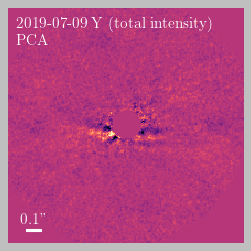

In [10]:
# IFS
filt='Y'
namesave = 'im_obs_reduced_pca_{}_{}ncomp_IFS_{}'.format(epoch, idx_pcs+1,filt)
im = np.copy(im_reduced)
im_crop_PCA = 13
im_crop = im_crop_PCA



print('Size of the image =', len(im), 'and crop PCA =', im_crop, 'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = -2e-2, 2e-2
text = '{} {}\n{}'.format(epoch, filt, algo)
text = '{} {} (total intensity)\n{}'.format(epoch, filt, algo)

plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, figsize=figsize, do_tight_layout=0,
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, platescale=platescale,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         right=right, left=left, top=top, bottom=bottom,
         add_text=1, text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

In [11]:
204*pixel_scale

1.5218399999999999

In [12]:
124*12.25*1e-3

1.5190000000000001

## GreeDS

In [50]:
idx, idx_pcs, before_or_after,sorting = 5, 104, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
instru = str(dF['instrument'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'GreeDS'
path_im_reduced = infolder + folder_reduced + algo + '/{}/{}*/*/*good.fits'.format(epoch,instru)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/GreeDS/2019-07-09/IRDIS*/*/*good.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/GreeDS/2019-07-09/IRDIS/results_2022-12-13/GreeDS_estimation_30_5_10_good.fits


Size of the image = 200 and crop PCA = 38 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-4-12/im_obs_reduced_greeds_2019-07-09


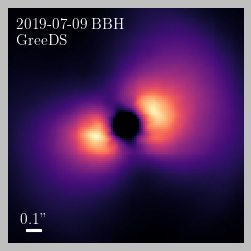

In [51]:
namesave = 'im_obs_reduced_greeds_{}'.format(epoch)
im = np.copy(im_reduced)
im_crop_GREEDS = 38
im_crop = im_crop_GREEDS

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 
      'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = None, None #0, 0.2

text = '{} {}\n{}'.format(epoch, filt, algo)

plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         right=right, left=left, top=top, bottom=bottom,
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

## MUSTARD

In [48]:
idx, idx_pcs, before_or_after,sorting = -1, 10, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'MUSTARD'
path_im_reduced = infolder + folder_reduced + algo + '/*{}*.fits'.format(epoch)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])#[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/MUSTARD/*2019-07-09*.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/MUSTARD/Mustard_2019-07-09_IRDIS_H2.fits


Size of the image = 126 and crop PCA = 1 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-4-12/im_obs_reduced_mustard_2019-07-09


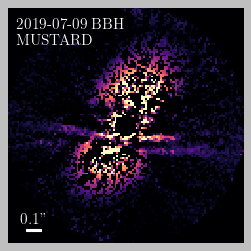

In [49]:
namesave = 'im_obs_reduced_mustard_{}'.format(epoch)
im = np.copy(im_reduced)
im_crop_MUSTARD = 1
im_crop = im_crop_MUSTARD

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 
      'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = 0, 0.2

text = '{} {}\n{}'.format(epoch, filt, algo)


plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

## FEVES

In [38]:
idx, idx_pcs, before_or_after,sorting = -1, 1, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'FEVES'
path_im_reduced = infolder + folder_reduced + algo + '/*/*.fits'.format(epoch)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/FEVES/*/*.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/FEVES/result_2022-12-13/autoFEVES0_npc3_frac1-5.fits


Size of the image = 171 and crop PCA = 23 i.e. size of the image shown = 125
The file is saved here:
 figs/fig_v2023-4-12/im_obs_reduced_feves_2019-07-09


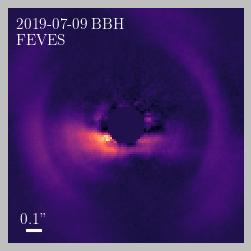

In [46]:
namesave = 'im_obs_reduced_{}_{}'.format(algo.lower(), epoch)
im = np.copy(im_reduced)
im_crop_FEVES = 23
im_crop = im_crop_FEVES

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 
      'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = None, None

text = '{} {}\n{}'.format(epoch, filt, algo)

im[np.isnan(im)]=0
plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

#### FEVES level0 (without fractioning)

In [30]:
idx, idx_pcs, before_or_after,sorting = -1, 9, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
print('Load the epoch: {}'.format(epoch))
algo = 'PCA_iterative'
path_im_reduced = infolder + folder_reduced + algo + '/*/*.fits'.format(epoch)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    algo = 'IRDAP/'
    path_im_reduced = infolder + folder_reduced + algo + '{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)
        
print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])[idx_pcs]

Load the epoch: 2019-07-09
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_iterative/*/*.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_iterative/result_2022-12-19/itsPCA_ADI0_npc1-10.fits
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/PCA_iterative/result_2022-12-19/itsPCA_ADI2_npc1-10.fits


Size of the image = 128 and crop PCA = 2 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-6-16/im_obs_reduced_pca_iterative_2019-07-09_10ncomp


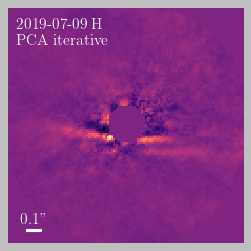

In [31]:
namesave = 'im_obs_reduced_{}_{}_{}ncomp'.format(algo.lower(), epoch, idx_pcs+1)
im = np.copy(im_reduced)
im = im[:-1,:-1]
im_crop_FEVES = 2
im_crop = im_crop_FEVES

print('Size of the image =', len(im), 'and crop PCA =', im_crop, 
      'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = None, None

text = '{} {}\n{}'.format(epoch, filt, algo).replace('_',' ')


plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

## IRDAP

In [69]:
idx, idx_pcs, before_or_after,sorting = 3, 10, 'after', 'softsorting'
epoch = str(dF['epoch'].iloc[idx])
filt =  str(dF['filter'].iloc[idx])
print(filt)
if filt == 'BB_H': filt = 'H'
if filt == 'H23': filt = 'H2'
algo = 'IRDAP'
print('Load the epoch: {}'.format(epoch))
path_im_reduced = infolder + folder_reduced + algo + '/*{}*{}*{}_cube_im_pca.fits'.format(epoch,before_or_after,sorting)
obs_polar = str(dF['polar'].iloc[idx])
if obs_polar == 'yes': 
    print('(!) polarized light')
    path_im_reduced = infolder + folder_reduced + algo + '/{}/reduced_pdi/star_pol*/*Q_phi*.fits'.format(epoch)

print('It corresponds do the path:\n{}'.format(path_im_reduced))
print('\nFiles found:')
flist = glob(path_im_reduced)
for f in flist: print('-',f)
im_reduced = fits.getdata(flist[0])#[idx_pcs]

BB_H
Load the epoch: 2018-06-01
(!) polarized light
It corresponds do the path:
/Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol*/*Q_phi*.fits

Files found:
- /Users/desgranc/Documents/work/projects/HD120326/data/reduced/IRDAP/2018-06-01/reduced_pdi/star_pol_subtr/HIP67497_2018-06-02_Q_phi_star_pol_subtr.fits


In [70]:
filt 

'H'

Size of the image = 1024 and crop = 450 i.e. size of the image shown = 124
The file is saved here:
 figs/fig_v2023-6-19/im_obs_reduced_irdap_2018-06-01


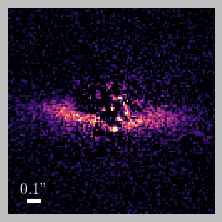

In [74]:
namesave = 'im_obs_reduced_{}_{}'.format(algo.lower(), epoch)
im = np.copy(im_reduced)
im_crop_IRDAP = 450
im_crop = im_crop_IRDAP

print('Size of the image =', len(im), 'and crop =', im_crop, 
      'i.e. size of the image shown =',  len(im)-2*im_crop)

clab = 'contrast'
vmin, vmax = 0, 40

text = '{} {}\n{}'.format(epoch, filt, algo)
text = '{} {} (polar)\n{}'.format(epoch, filt, algo)


plot_fig(im=im, vmin=vmin, vmax=vmax, im_crop=im_crop, 
         scalebar_pix=scalebar_pix, scalebar_leg=scalebar_leg, 
         platescale=platescale, figsize=figsize,
         add_colorbar=add_colorbar, clab=clab, cbar_xdeb=cbar_xdeb, 
         text=text, text_xfrac=text_xfrac, text_yfrac=text_yfrac,
         right=right, left=left, top=top, bottom=bottom,
         saving_dir=saving_dir, save_png=save_png, namesave=namesave)

# Test

In [ ]:
def plot_fig(im, clab='', vmin=None, vmax=None, text='None', text_xfrac=0.03, text_yfrac=0.9,
        show_axis_ticks='off', im_crop=0,
        scalebar_pix=100, scalebar_leg='100 mas', platescale=12.25,
        add_colorbar=1, cbar_xdeb=0.82, right=0.8, top=0.95, left=0.01, bottom=0.05, figsize=(5,4),
        interpolation='nearest', saving_dir='', namesave='test', save_png=0, cmap='magma', norm=None,
        return_fig_ax=False, give_fig_ax=False):

    if not give_fig_ax: 
        fig, ax = plt.subplots(1,1, figsize=figsize)
    fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom)
    ax.axis(show_axis_ticks)

    if im_crop != 0: im = im[im_crop:-im_crop,im_crop:-im_crop]

    if vmin != None and vmax != None: im_plot = ax.imshow(im, vmin=vmin, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    elif vmax != None : im_plot = ax.imshow(im, vmax=vmax, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    elif vmin != None : im_plot = ax.imshow(im, vmin=vmin, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)
    else : im_plot = ax.imshow(im, origin='lower', interpolation=interpolation, cmap=cmap, norm=norm)

    # Add text
    if text != 'None':
        w,h = np.shape(im)
        ax.text(w*text_xfrac,h*text_yfrac,text,color='white')

    # Add scalebar
    scalebar = AnchoredSizeBar(ax.transData, scalebar_pix/platescale, scalebar_leg, 3, label_top=True, pad=0.4,
                               sep=2, borderpad=0.5, frameon=False, size_vertical=1, color='white')#,fontproperties=fp)
    ax.add_artist(scalebar)

    # Add colorbar
    if add_colorbar:
        # Color bar
        cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth = cbar_xdeb, 0.1, 0.03, 0.8
        cb_ax = fig.add_axes([cb_xdeb, cb_ydeb, cb_xwidth, cb_ywidth])

        cbar = fig.colorbar(im_plot, cax=cb_ax, orientation='vertical', #drawedges=True,
                            pad=0.8, shrink=0.05,fraction=0.01,aspect=50)#,width_fraction=0.001)

        cbar.set_label(clab)
    
    if return_fig_ax: return fig, ax
    else: 
        print('The file is saved here:\n', saving_dir+namesave)
        plt.savefig(saving_dir+namesave+'.pdf')
        if save_png: plt.savefig(saving_dir+namesave+'.png', dpi=200)
        plt.show()